In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
from pathlib import Path
from copy import deepcopy
from typing import Tuple, List, Callable

import numpy as np
import pandas as pd
import glob
from datetime import datetime, timedelta
from pyproj import Geod
from tqdm import tqdm
import matplotlib.pyplot as plt


import folium
import folium.plugins

In [3]:
wgs84_geod = Geod(ellps='WGS84') # Distance will be measured in meters on this ellipsoid - more accurate than a spherical method
def distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) # Yes, this order is correct
    return dist

def coords_to_areas(target: pd.Series) -> pd.Series: # Calculate to which area an opening's coordinates (target) "belong to"
    # Following 3 lines needed to have a Series of the same length as area_centers with target as value
    dist = deepcopy(area_centers) # Without deepcopy area_centers is modified in the next 2 lines
    dist['TGPS_Latitude'] = target['GPS_Latitude']
    dist['TGPS_Longitude'] = target['GPS_Longitude']
    
    dist = distance(dist['GPS_Latitude'], dist['GPS_Longitude'], dist['TGPS_Latitude'], dist['TGPS_Longitude'])
    return pd.Series(1 - dist / sum(dist)) # Percentage of how much an opening belongs to each area

In [4]:
if (Path.cwd().parent / 'data' / 'interim' / 'rental.csv').is_file():
    rental = pd.read_csv(Path.cwd().parent / 'data' / 'interim' / 'rental.csv', low_memory=False)
    area_centers = pd.read_csv(Path.cwd().parent / 'data' / 'interim' / 'areas.csv')
    area_centers.set_index('Area', inplace=True)
else:
    rent_files = glob.glob(str(Path.cwd().parent / 'data' / 'raw' / 'SN rentals' / '*.xlsx'))
    rent_dfs = [pd.read_excel(f, skiprows=[0,1]) for f in rent_files]

    rental = pd.concat(rent_dfs,ignore_index=True)
    rental = rental[rental['[Partner_Rental_ID]']!='[Partner_Rental_ID]']
    rental.columns = rental.columns.str.replace("[","", regex=False)
    rental.columns = rental.columns.str.replace("]","", regex=False)
    rental = rental.loc[:, ['Vehicle_Number_Plate', 'Vehicle_Engine_Type', 'Vehicle_Model', 'Revenue_Net',
                        'Start_Datetime_Local', 'End_Datetime_Local',
                        'Start_GPS_Latitude', 'Start_GPS_Longitude',
                        'End_GPS_Latitude', 'End_GPS_Longitude', 'Package_Description',
                        'Operation_State_Name_Before', 'Operation_State_Name_After',
                        'Start_Zone_Name', 'End_Zone_Name', 'Reservation_YN', 'Prebooking_YN', 'Servicedrive_YN']]
    
    area_centers = rental.groupby('End_Zone_Name').mean()[['End_GPS_Latitude','End_GPS_Longitude']]
    area_centers.rename(columns={'End_GPS_Latitude': 'GPS_Latitude', 'End_GPS_Longitude': 'GPS_Longitude'}, inplace=True)
    area_centers.index.names = ['Area']
    
    area_centers.to_csv(Path.cwd().parent / 'data' / 'interim' / 'areas.csv')
    rental.to_csv(Path.cwd().parent / 'data' / 'interim' / 'rental.csv', index=False)
    del rent_files, rent_dfs

if (Path.cwd().parent / 'data' / 'interim' / 'openings.csv').is_file():
    openings = pd.read_csv(Path.cwd().parent / 'data' / 'interim' / 'openings.csv')
else:
    open_files = glob.glob(str(Path.cwd().parent / 'data' / 'raw' / 'SN App requests' / '*.csv'))
    open_dfs = [pd.read_csv(f) for f in open_files]

    openings = pd.concat(open_dfs,ignore_index=True)
    openings = openings[openings['Source_Location_ID']!='Source_Location_ID']
    openings = openings.loc[:, ['Created_Datetime_Local', 'Platform', 'GPS_Longitude', 'GPS_Latitude']]
    

    openings.to_csv(Path.cwd().parent / 'data' / 'interim' / 'openings.csv', index=False)
    del open_files, open_dfs

In [5]:
rental['Start_Datetime_Local'] = pd.to_datetime(rental['Start_Datetime_Local'], format='%Y-%m-%d %H:%M')
rental['End_Datetime_Local'] = pd.to_datetime(rental['End_Datetime_Local'], format='%Y-%m-%d %H:%M')
rental = pd.get_dummies(rental, columns=['Vehicle_Engine_Type'], drop_first=True)
rental = pd.get_dummies(rental, columns=['Vehicle_Model'])

In [6]:
openings['Created_Datetime_Local'] = pd.to_datetime(openings['Created_Datetime_Local'], format='%Y-%m-%d %H:%M')
openings = pd.get_dummies(openings, columns=['Platform'], drop_first=True)

In [7]:
ratio = []
for i in tqdm(range(10)):
    timepoint = datetime(2020, 8, 1, 1, 0) + timedelta(hours=i)
    filtered_rentals = rental[rental['End_Datetime_Local'] <= timepoint].drop('Revenue_Net', axis=1)
    filtered_rentals = filtered_rentals.sort_values(by='End_Datetime_Local').drop_duplicates(subset='Vehicle_Number_Plate', keep='last') # Keep the last location
    current_trips = rental[(rental['Start_Datetime_Local'] <= timepoint) & (rental['End_Datetime_Local'] > timepoint)] # Cars in use
    ratio.append(len(current_trips)/len(filtered_rentals))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


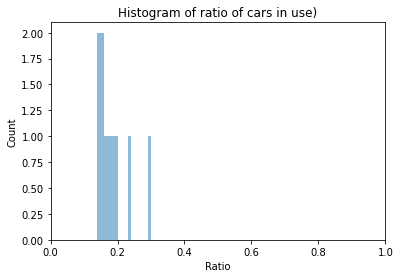

In [8]:
bins = np.arange(0, 1, 0.01) # fixed bin size

plt.xlim([0, 1])

plt.hist(ratio, bins=bins, alpha=0.5)
plt.title('Histogram of ratio of cars in use)')
plt.xlabel('Ratio')
plt.ylabel('Count')

plt.show()

In [9]:
time_start = max(rental['Start_Datetime_Local'].min(), openings['Created_Datetime_Local'].min())
time_end = min(rental['End_Datetime_Local'].max(), openings['Created_Datetime_Local'].max())
print('Time limits:', time_start, 'to', time_end)

Time limits: 2020-02-01 00:56:26 to 2021-05-03 23:59:51


In [10]:
def actions(timepoint:datetime, window:timedelta=timedelta(hours=1)):
        a = rental[(rental['Servicedrive_YN']==1) &
                        (rental['Start_Datetime_Local'] >= timepoint-window) &
                        (rental['End_Datetime_Local'] < timepoint)]
        all_vehicles = rental.columns[rental.columns.str.contains('Vehicle_Model')] # Get name of vehicles
        a = a[a['Start_Zone_Name'] != a['End_Zone_Name']]
        a = a.loc[:, [*all_vehicles, 'Start_Zone_Name', 'End_Zone_Name', 'Servicedrive_YN']]
        a = pd.melt(a, id_vars=['Start_Zone_Name', 'End_Zone_Name'], value_vars=[*all_vehicles])
        a.rename(columns={'variable': 'Vehicle_Model'}, inplace=True)
        #return a
        return a.groupby(['Vehicle_Model', 'Start_Zone_Name', 'End_Zone_Name']).sum().unstack()

In [11]:
actions(timepoint=datetime(2020, 6, 12, 12, 0, 0), window=timedelta(hours=2))

value  \
End_Zone_Name                                                                    -   
Vehicle_Model               Start_Zone_Name                                          
Vehicle_Model_ACLASS        Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_BCLASS        Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_BMW_1ER       Københavns Lufthavn                                1.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_BMW_I3        Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_BMW_X1        Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_CLA           Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_FIAT_500      Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_MINI_3-TUERER Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_MINI_5-TUERER Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_MINI_BEV      Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   
Vehicle_Model_TBD           Københavns Lufthavn                                0.0   
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530   NaN   

                                                                                                  
End_Zone_Name                                                                Københavns Lufthavn  
Vehicle_Model               Start_Zone_Name                                                       
Vehicle_Model_ACLASS        Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_BCLASS        Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_BMW_1ER       Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_BMW_I3        Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 1.0  
Vehicle_Model_BMW_X1        Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_CLA           Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_FIAT_500      Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_MINI_3-TUERER Københavns Lufthavn                                              NaN  
                            Skøjtevej 261084814a-dc92-4564-abc0-540d720d9530                 0.0  
Vehicle_Model_MINI_5-TUERER Københavns Luftha

In [12]:
# Function that returns time openings in the last time window at any datetime. Softmax preferred False to get absolute values (an increase in demand everywhere -> softmax is the same)
def demand(timepoint:datetime, window:timedelta=timedelta(hours=1), app_openings:pd.DataFrame=openings, detail:bool=False) -> pd.DataFrame:
    demand_df = deepcopy(app_openings[(app_openings['Created_Datetime_Local'] > timepoint-window) &
                             (app_openings['Created_Datetime_Local'] <= timepoint)])
    demand_df[area_centers.index.values] = 0 # Create columns with area names
    demand_df[area_centers.index.values] = demand_df.apply(coords_to_areas, axis=1) # Apply function to all openings
    if detail:
        return demand_df
    else:
        demand_df = demand_df.sum(axis=0).loc[area_centers.index] # Aggregate demand in the time window over areas (.loc to remove gps coords and platform)se:
        return pd.DataFrame(demand_df, columns=['demand']) # Sum of demand equals to amount of app openings

In [13]:
# Function that returns the location of all parked vehicles at any datetime. remove_in_use decides to remove vehicles in transit or keep them and pick their last location
def vehicle_locations(timepoint:datetime, rentals:pd.DataFrame=rental, detail:bool=False, remove_in_use:bool=True) -> pd.DataFrame:
    filtered_rentals = rentals[rentals['End_Datetime_Local'] <= timepoint].drop('Revenue_Net', axis=1)
    filtered_rentals = filtered_rentals.sort_values(by='End_Datetime_Local').drop_duplicates(subset='Vehicle_Number_Plate', keep='last') # Keep the last location
    if remove_in_use:
        current_trips = rentals[(rentals['Start_Datetime_Local'] <= timepoint) & (rentals['End_Datetime_Local'] > timepoint)] # Cars in use
        filtered_rentals = filtered_rentals[~filtered_rentals['Vehicle_Number_Plate'].isin(current_trips['Vehicle_Number_Plate'])] # Filter out cars in use
    filtered_rentals = filtered_rentals.loc[:, ~filtered_rentals.columns.str.contains('Start')].drop(columns=['End_Datetime_Local'], axis=1) # Drop unused columns
    filtered_rentals.rename(columns={'End_GPS_Latitude': 'GPS_Latitude', 'End_GPS_Longitude': 'GPS_Longitude', 'End_Zone_Name': 'Zone'}, inplace=True)
    if detail:
        filtered_rentals = pd.get_dummies(filtered_rentals, columns=['Zone'])
        filtered_rentals.columns = filtered_rentals.columns.str.replace('^Zone_', '', regex=True) # Remove area_ prefix in columns
        return filtered_rentals
    else:
        all_vehicles = filtered_rentals.columns[filtered_rentals.columns.str.contains('Vehicle_Model')] # Get name of vehicles
        filtered_rentals = filtered_rentals.groupby('Zone')[all_vehicles].sum() # Aggregate amount of cars
        missing_areas = pd.DataFrame(index=area_centers.index[~area_centers.index.isin(filtered_rentals.index)], columns=filtered_rentals.columns, data=0)
        return pd.concat([filtered_rentals, missing_areas]).sort_index() # Add missing areas, sort and return

In [14]:
# Function that returns the total revenue in the last time window at any datetime
def revenue(timepoint:datetime, window:timedelta=timedelta(hours=1), rentals:pd.DataFrame=rental) -> float:
    trips_in_window = rentals[(rentals['Start_Datetime_Local'] >= timepoint-window) & (rentals['End_Datetime_Local'] < timepoint)]
    return trips_in_window['Revenue_Net'].sum()

In [15]:
def get_data(timepoint:datetime, windows:List[timedelta]=[timedelta(hours=1)], coords:bool=False) -> Tuple[Tuple[float], Tuple[pd.DataFrame]]:
    df = deepcopy(area_centers)
    df = pd.concat([df, vehicle_locations(timepoint=timepoint)], axis=1) # Locations now
    dfs = []
    revenues = []
    for time_window in windows:
        locs = vehicle_locations(timepoint=timepoint-time_window, remove_in_use=False) # Locations at beginning of time window
        dem = demand(timepoint=timepoint, window=time_window) # Demand in time window
        locs.columns = locs.columns + '_' + str(int(time_window.days*24 + time_window.seconds/3600)) + 'h' # Add time window to column name
        dem.columns = dem.columns + '_' + str(int(time_window.days*24 + time_window.seconds/3600)) + 'h' # Add time window to column name
        df = pd.concat([df, dem, locs], axis=1) # Add demands and locations to final dataframe
        revenues.append(revenue(timepoint=timepoint, window=time_window))
        if coords:
            dfs.append(df)
        else:
            dfs.append(df.iloc[:,3:])
    return tuple(revenues), tuple(dfs)

In [16]:
r, df = get_data(timepoint=datetime(2020, 6, 12, 12, 0, 0),
                 windows=[timedelta(hours=1)])

In [17]:
r[0]

2340.4

In [18]:
df[0]

,Vehicle_Model_BCLASS,Vehicle_Model_BMW_1ER,Vehicle_Model_BMW_I3,Vehicle_Model_BMW_X1,Vehicle_Model_CLA,Vehicle_Model_FIAT_500,Vehicle_Model_MINI_3-TUERER,Vehicle_Model_MINI_5-TUERER,Vehicle_Model_MINI_BEV,Vehicle_Model_TBD,...,Vehicle_Model_BCLASS_1h,Vehicle_Model_BMW_1ER_1h,Vehicle_Model_BMW_I3_1h,Vehicle_Model_BMW_X1_1h,Vehicle_Model_CLA_1h,Vehicle_Model_FIAT_500_1h,Vehicle_Model_MINI_3-TUERER_1h,Vehicle_Model_MINI_5-TUERER_1h,Vehicle_Model_MINI_BEV_1h,Vehicle_Model_TBD_1h
-,0,54,50,8,0,0,12,24,0,0,...,0,54,56,10,0,0,13,25,0,0
A.P Møllers Allé 55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DN Airport End,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTU Ballerup,0,2,4,0,0,0,0,0,0,0,...,0,1,5,0,0,0,0,0,0,0
DTU Lyngby,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virum - Geels Plads 2-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Virum - Grønnevej 48-50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Virum - Skovbrynet kirkegård,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Virum - Sorgenfri Torv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# open_map_heat = folium.Map([55.6785706133019, 12.594427257404426], zoom_start=12, tiles='Stamen Toner')

# folium.plugins.HeatMap(openings[["gps_latitude", "gps_longitude"]], name=None, min_opacity=0.5, max_zoom=18, radius=20,
# blur=15, gradient=None, overlay=True, control=True, show=True
# ).add_to(open_map_heat)
# open_map_heat

In [20]:
# start_map_heat = folium.Map([55.6785706133019, 12.594427257404426], zoom_start=12, tiles='Stamen Toner')

# folium.plugins.HeatMap(rental[["start_gps_latitude", "start_gps_longitude"]], name=None, min_opacity=0.5, max_zoom=18, radius=20,
# blur=15, gradient=None, overlay=True, control=True, show=True
# ).add_to(start_map_heat)
# start_map_heat